# Desafio Técnico

Neste desafio será tratado um case de classificação de contas ilícitas, que objetiva avaliar o candidato nas principais hard skills necessárias no dia a dia do time.

Será fornecido o link de um arquivo .zip que ao ser descompactado apresenta um banco de dados SQLite denominado desafio-tecnico.db para o desenvolvimento das análises. **Ressalta-se que os dados presentes neste banco foram simulados e, consequentemente, não representam nenhum cliente ou pessoa real. Além disso, os insights observados nas análises não podem ser extrapolados para a base de clientes Gerencianet.**

## Dados

1 - accounts
Tabela que apresenta as informações cadastrais de cada conta.

Colunas:

* id: ID identificador da tabela
* account_number: Número da conta
* birth: Data de nascimento
* occupation: Tipo de negócio autodeclarado
* email: E-mail da conta
* address_id: ID identificador da tabela address
* created_at: Data de criação da conta

2 - address
Tabela que identifica os pares de estado e cidade. Para verificar a residência de cada conta é necessário realizar o join com esta tabela.

* id: ID identificador da tabela
* state: Estado de residência do cliente
* city: Cidade de residência do cliente

3 - levels
Cada conta recebe uma classificação de acordo com a forma que utiliza a plataforma. Contas que utilizam com maior consistência ou com grande potêncial podem receber uma melhor classificação (A>B>C>D). Caso identifique-se que a conta possui características suspeitas, de fraude, é atribuida a categoria F e executado o encerramento.

* id: ID identificador da tabela
* account_number: Número da conta
* level: A, B, C, D e F
* created_at: Data da classificação

4 - charges
Tabela apresenta as emissões de boletos realizadas pelos clientes com os respectivos status de pago ou não.

* id: ID identificador da tabela
* account_number: Número da conta
* status: Status da cobrança [paid, unpaid]
* value: Valor da cobrança (em centavos)
* created_at: Data de criação do boleto

5 - transactions
Tabela com as transações efetivadas por cada conta, logo, caso um boleto tenha sido pago esta informação estará presente nesta tabela e na tabela charges.

* id: ID identificador da tabela
* account_number: Número da conta
* transaction_type_id: ID identificador da tabela transaction_type
* value: Valor da transação (em centavos)
* created_at: Data da transação

6 - transaction_type
Tabela que permite identificar qual o tipo de cada transação da tabela transactions.

* id: ID identificador da tabela
* description: boleto_recebido, pix_enviado e pix_recebido
* description_long: 'BOLETO RECEBIDO PELO CLIENTE', 'PIX ENVIADO PELO CLIENTE PARA UMA CONTA EXTERNA' e 'PIX RECEBIDO PELO CLIENTE'

# Entrega

Espera-se do candidato o desenvolvimento dos seguintes passos:

1 - Conectar ao banco e desenvolver as querys para obter os dados

2 - Realizar análise descritiva dos dados utilizando linguagem R ou Python. Os resultados e códigos desta análise devem ficar salvos em um arquivo gerado via Rmarkdown ou Jupyter Notebook

3 - Desenvolver um modelo, linguagem R ou Python, para classificar as contas em lícitas ou ilícitas utilizando as estratégias e métricas que julgar relevantes dado o escopo do problema.

4 - Disponibilizar a classificação obtida pelo modelo das contas presentes no banco que não possuem classificação na tabela levels, escolhendo estre as seguintes opções:
* Opção 1: Deploy de uma API que disponibiliza um endpoit GET que recebe como parâmetro na URL o número da conta e retorna o valor 0 para conta que o modelo considere lícita e 1 caso o modelo considere ilícita. A rota deve seguir a seguinte estrutura: URL/?account_number=12345
* Opção 2: Gerar um csv com as colunas account_number e fraud. Sendo que a coluna fraud deve ter os seguintes valores: 0 para contas lícitas e 1 para ilícitas

O desafio deve ser entregue no espaço em branco abaixo, a partir de um link público do Google Drive com uma pasta contendo os códigos e estrutura desenvolvida.

Será avaliado na entrega a correta interpretação dos dados e do problema, os resultados obtidos pelo modelo e a utilização de boas práticas de programação e arquitetura.


Link para base de dados: https://s3.amazonaws.com/gerencianet-pub-prod-1/printscreen/2021/desafio-tecnico.zip

Link úteis de apoio:
* https://db.rstudio.com/databases/sqlite/
* https://docs.python.org/3/library/sqlite3.html
* https://fastapi.tiangolo.com/deployment/
* https://icaroagostino.github.io/post/plumber/

### Instalação das bibliotecas necessárias

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sqlite3
!pip install requests
!pip install zipfile
!pip install sklearn
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: h

## 1 - Conexão com o Banco de Dados e Obtenção dos Dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import requests  
import zipfile

Download e Extração da Base de Dados

In [3]:
database_url = "https://s3.amazonaws.com/gerencianet-pub-prod-1/printscreen/2021/desafio-tecnico.zip"
 
r = requests.get(database_url)

with open("desafio-tecnico.zip",'wb') as f:
  f.write(r.content)

with zipfile.ZipFile("desafio-tecnico.zip","r") as zip_ref:
    zip_ref.extractall()

Conexão com o banco de dados

In [4]:
import sqlite3
con = sqlite3.connect('desafio-tecnico.db')

Obtenção da tabela 'acounts' e criação do dataframe de contas

In [5]:
cur = con.cursor()

accounts_list = []
for account in cur.execute('SELECT * FROM accounts ORDER BY id'):
  accounts_list.append(account)

accounts_df = pd.DataFrame(accounts_list, columns=['id', 'account_number', 'birth', 'ocupation', 'email', 'address_id', 'created_at'])

Obtenção da tabela 'address' e criação do dataframe de endereços

In [6]:
address_list = []
for address in cur.execute('SELECT * FROM address ORDER BY id'):
  address_list.append(address)

address_df = pd.DataFrame(address_list, columns=['id', 'state', 'city', 'created_at'])

Obtenção da tabela 'levels' e criação do dataframe de níveis das contas

In [7]:
levels_list = []
for level in cur.execute('SELECT * FROM levels ORDER BY id'):
  levels_list.append(level)

levels_df = pd.DataFrame(levels_list, columns=['id', 'account_number', 'level', 'created_at'])

Obtenção da tabela 'charges' e criação do dataframe de emissões de boletos

In [8]:
charges_list = []
for charge in cur.execute('SELECT * FROM charges ORDER BY id'):
  charges_list.append(charge)

charges_df = pd.DataFrame(charges_list, columns=['id', 'account_number', 'status', 'value', 'created_at'])

Obtenção da tabela 'transactions' e criação do dataframe de transações efetivadas por cada conta

In [9]:
transactions_list = []
for transaction in cur.execute('SELECT * FROM transactions ORDER BY id'):
  transactions_list.append(transaction)

transactions_df = pd.DataFrame(transactions_list, columns=['id', 'account_number', 'transaction_type_id', 'value', 'created_at'])

Obtenção da tabela 'transaction_type' e criação do dataframe de tipos de transações

In [10]:
transaction_types_list = []
for transaction_type in cur.execute('SELECT * FROM transaction_type ORDER BY id'):
  transaction_types_list.append(transaction_type)

transaction_types_df = pd.DataFrame(transaction_types_list, columns=['id', 'description', 'description_long'])

In [11]:
con.close()

## 2 - Análise descritiva dos dados

### Tabela de contas

In [12]:
accounts_df.head()

,id,account_number,birth,ocupation,email,address_id,created_at
0,1,155938,1984-10-29,Outros,mariaceciliaazevedo042@example.com,1,2021-04-01 02:30:00
1,2,747007,1977-03-26,Corretor,ananunes3@example.com,2,2021-04-01 02:00:00
2,3,208404,1984-01-26,Analista,luizfernandovieira@example.com,3,2021-04-01 11:30:00
3,4,66402,1982-06-30,Investidor,gabriellynascimento6@example.com,4,2021-04-01 14:30:00
4,5,277012,1967-01-11,Outros,aliciagoncalves7@example.com,5,2021-04-02 15:30:00


In [13]:
display('Tipo dos dados presentes')
display(accounts_df.dtypes)

'Tipo dos dados presentes'

id                 int64
account_number     int64
birth             object
ocupation         object
email             object
address_id         int64
created_at        object
dtype: object

id: Númerico

account_number: Numérico

birth: Numérico

ocupation: Categórico Nominal

email: Categórico Nominal

address_id: Numérico

created_at: Numérico

#### Como se distribuem os titulares das contas, de acordo com a sua ocupação declarada?

,ocupation,quantidade,quantidade relativa
0,Autonomo,63,6.12
1,Investidor,117,11.37
2,Outros,165,16.03
3,Corretor,216,20.99
4,Desenvolvedor,221,21.48
5,Analista,247,24.00
6,Total,1029,100.00


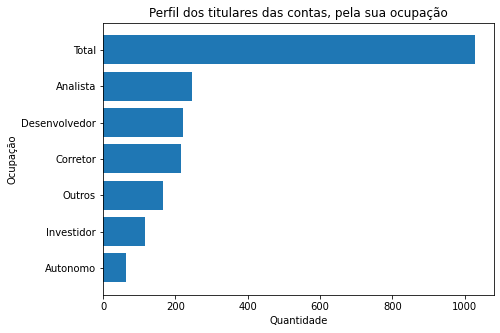

In [14]:
ocupacoes_df = accounts_df.groupby(['ocupation']).count().reset_index().sort_values('id', ascending=True).reset_index()
ocupacoes_df = ocupacoes_df[['ocupation', 'id']]
ocupacoes_df.rename(columns = {'id': 'quantidade'}, inplace = True)

percentual = []
total = ocupacoes_df['quantidade'].sum()
for quantidade in ocupacoes_df['quantidade']:
  percentual.append(round((quantidade / total) * 100, 2))

ocupacoes_df['quantidade relativa'] = percentual

ocupacoes_df.loc[ocupacoes_df.shape[0]] = ['Total', ocupacoes_df['quantidade'].sum(), 100]

display(ocupacoes_df)
print()

plt.figure(figsize=(7,5))
plt.barh(ocupacoes_df['ocupation'], ocupacoes_df['quantidade'])
plt.title('Perfil dos titulares das contas, pela sua ocupação')
plt.ylabel('Ocupação')
plt.xlabel('Quantidade')
plt.show()

De acordo com a ocupação, a maior parte dos titulares de contas são analistas (247) ou desenvolvedores (221), seguidos pelos corretores (216). Os investidores (117) e os autônomos (63) representam a menor parcela de titulares. Em 165 contas os titulares não declararam o tipo de negócio.

### Tabela de endereços

In [15]:
address_df.head()

,id,state,city,created_at
0,1,RJ,Carmo,2021-04-01 02:30:00
1,2,MG,Bertopolis,2021-04-01 02:00:00
2,3,MG,Olaria,2021-04-01 11:30:00
3,4,PR,Icaraima,2021-04-01 14:30:00
4,5,ES,Ecoporanga,2021-04-02 15:30:00


In [16]:
display('Tipo dos dados presentes')
display(address_df.dtypes)

'Tipo dos dados presentes'

id             int64
state         object
city          object
created_at    object
dtype: object

id: Numérico

state: Categórico Nominal

city: Categórico Nominal

created_at: Numérico

#### Como se distribuem os endereços dos titulares das contas, de acordo com o estado?

,state,quantidade,quantidade relativa
0,GO,43,5.76
1,SC,45,6.02
2,SP,47,6.29
3,BA,50,6.69
4,ES,62,8.30
5,RJ,80,10.71
6,PR,159,21.29
7,MG,261,34.94
8,Total,747,100.00


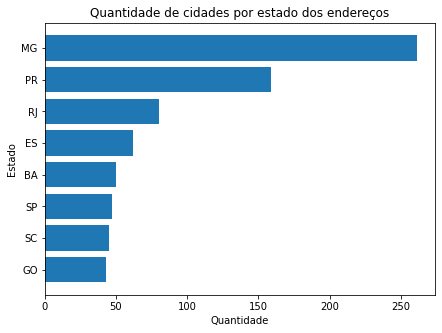

In [17]:
estados_df = address_df.groupby(['state']).count().reset_index().sort_values('id', ascending=True).reset_index()
estados_df = estados_df[['state', 'id']]
estados_df.rename(columns = {'id': 'quantidade'}, inplace = True)

percentual = []
total = estados_df['quantidade'].sum()
for quantidade in estados_df['quantidade']:
  percentual.append(round((quantidade / total) * 100, 2))

estados_df['quantidade relativa'] = percentual

estados_df.loc[estados_df.shape[0]] = ['Total', estados_df['quantidade'].sum(), 100]

display(estados_df)
print()

plt.figure(figsize=(7,5))
plt.barh(estados_df['state'].iloc[:-1], estados_df['quantidade'].iloc[:-1])
plt.title('Quantidade de cidades por estado dos endereços')
plt.ylabel('Estado')
plt.xlabel('Quantidade')
plt.show()

De acordo com o estado, a 34,94% dos endereços dos titulares de contas é de Minas Gerais. A Região Sudeste apresenta 60,24% dos endereços. Nenhum endereço da Região Norte está presente. Da Região Nordeste, apenas o estado Bahia possui endereços, 6,69%.

### Tabela de níveis

In [18]:
levels_df.head()

,id,account_number,level,created_at
0,1,155938,F,2021-04-20 08:00:00
1,2,747007,D,2021-04-19 19:30:00
2,4,66402,D,2021-04-28 21:00:00
3,5,277012,D,2021-04-19 12:00:00
4,6,228213,D,2021-04-26 15:00:00


In [19]:
display('Tipo dos dados presentes')
display(levels_df.dtypes)

'Tipo dos dados presentes'

id                 int64
account_number     int64
level             object
created_at        object
dtype: object

id: Númerico

account_number: Numérico

level: Categórico Nominal

created_at: Numérico

##### Como se distribuem as contas, de acordo com os níveis?

,level,quantidade,quantidade relativa
0,A,35,3.40
1,B,75,7.29
5,N,103,10.01
2,F,204,19.83
3,C,264,25.66
4,D,348,33.82
6,Total,1029,100.00


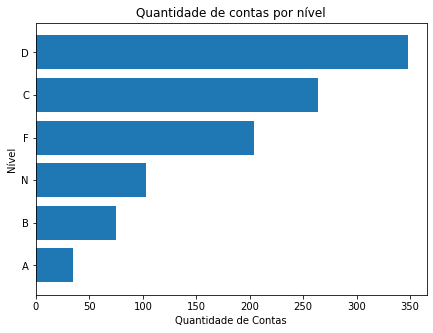

In [20]:
niveis_df = levels_df.groupby(['level']).count().reset_index().sort_values('id', ascending=True).reset_index()
niveis_df = niveis_df[['level', 'id']]
niveis_df.rename(columns = {'id': 'quantidade'}, inplace = True)

# Adicionando nível N para as contas sem nível definido
niveis_df.loc[niveis_df.shape[0]] = ['N', accounts_df.shape[0] - (niveis_df['quantidade'].sum())]
niveis_df = niveis_df.sort_values('quantidade', ascending=True)

percentual = []
total = niveis_df['quantidade'].sum()
for quantidade in niveis_df['quantidade']:
  percentual.append(round((quantidade / total) * 100, 2))

niveis_df['quantidade relativa'] = percentual

niveis_df.loc[niveis_df.shape[0]] = ['Total', niveis_df['quantidade'].sum(), 100]

display(niveis_df)
print()

plt.figure(figsize=(7,5))
plt.barh(niveis_df['level'].iloc[:-1], niveis_df['quantidade'].iloc[:-1])
plt.title('Quantidade de contas por nível')
plt.ylabel('Nível')
plt.xlabel('Quantidade de Contas')
plt.show()

A maior quantidade das contas possui nível D, C, e F. Para 103 contas não houve atribuição de nível.

### Tabela de emissões de boletos

In [21]:
charges_df.head()

,id,account_number,status,value,created_at
0,1,155938,paid,11992,2021-04-01 03:00:00
1,2,155938,paid,9689,2021-04-01 13:30:00
2,3,155938,paid,11579,2021-04-01 11:30:00
3,4,747007,unpaid,3134,2021-04-02 12:00:00
4,5,747007,paid,3085,2021-04-02 19:00:00


Conversão dos valores para reais

In [22]:
charges_df['value'] = charges_df['value'] / 100
charges_df.head()

,id,account_number,status,value,created_at
0,1,155938,paid,119.92,2021-04-01 03:00:00
1,2,155938,paid,96.89,2021-04-01 13:30:00
2,3,155938,paid,115.79,2021-04-01 11:30:00
3,4,747007,unpaid,31.34,2021-04-02 12:00:00
4,5,747007,paid,30.85,2021-04-02 19:00:00


In [23]:
display('Tipo dos dados presentes')
display(charges_df.dtypes)

'Tipo dos dados presentes'

id                  int64
account_number      int64
status             object
value             float64
created_at         object
dtype: object

id: Númerico

account_number: Numérico

status: Categórico Nominal

value: Numérico

created_at: Numérico

In [24]:
status_boleto_df = charges_df.groupby(['status'])
status_boleto_df = status_boleto_df['id'].count().reset_index().sort_values('id', ascending=True).reset_index()
status_boleto_df = status_boleto_df[['status', 'id']]
status_boleto_df.rename(columns = {'id': 'quantidade'}, inplace = True)
status_boleto_df

,status,quantidade
0,unpaid,57682
1,paid,96787


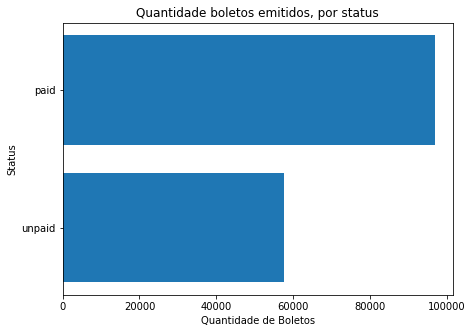

In [25]:
plt.figure(figsize=(7,5))
plt.barh(status_boleto_df['status'], status_boleto_df['quantidade'])
plt.title('Quantidade boletos emitidos, por status')
plt.ylabel('Status')
plt.xlabel('Quantidade de Boletos')
plt.show()

In [26]:
emissoes_de_boleto_df = charges_df.groupby(['account_number', 'status'])
emissoes_de_boleto_df = emissoes_de_boleto_df['id'].count().reset_index().sort_values('id', ascending=True).reset_index()
emissoes_de_boleto_df = emissoes_de_boleto_df[['account_number', 'status', 'id']]
emissoes_de_boleto_df.rename(columns = {'id': 'quantidade'}, inplace = True)
emissoes_de_boleto_df

,account_number,status,quantidade
0,871229,unpaid,1
1,418641,paid,1
2,960579,paid,1
3,741807,unpaid,1
4,947006,unpaid,2
...,...,...,...
1751,254087,paid,579
1752,830539,paid,588
1753,619093,paid,684
1754,850348,paid,693


In [27]:
boletos_pagos = (emissoes_de_boleto_df['status'] == 'paid')
boletos_nao_pagos = (emissoes_de_boleto_df['status'] == 'unpaid')

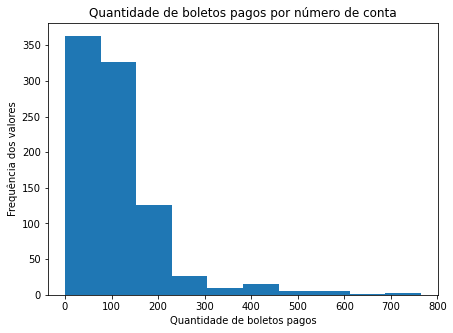

In [28]:
plt.figure(figsize=(7,5))
plt.hist(emissoes_de_boleto_df[boletos_pagos]['quantidade'], bins = 10)
plt.title('Quantidade de boletos pagos por número de conta')
plt.ylabel('Frequência dos valores')
plt.xlabel('Quantidade de boletos pagos')
plt.show()

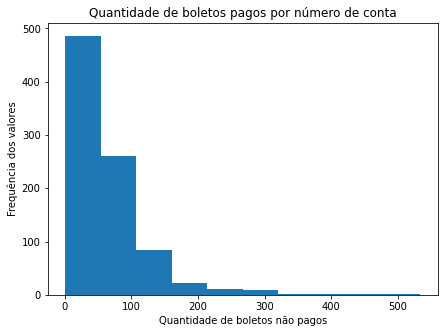

In [29]:
plt.figure(figsize=(7,5))
plt.hist(emissoes_de_boleto_df[boletos_nao_pagos]['quantidade'], bins = 10)
plt.title('Quantidade de boletos pagos por número de conta')
plt.ylabel('Frequência dos valores')
plt.xlabel('Quantidade de boletos não pagos')
plt.show()

### Tabela de transações efetivadas

In [30]:
transactions_df.head()

,id,account_number,transaction_type_id,value,created_at
0,1,155938,1,11992,2021-04-01 03:00:00
1,2,155938,1,9689,2021-04-01 13:30:00
2,3,155938,1,11579,2021-04-01 11:30:00
3,4,155938,3,11168,2021-04-01 11:00:00
4,5,155938,3,10772,2021-04-01 21:00:00


Conversão dos valores para reais

In [31]:
transactions_df['value'] = transactions_df['value'] / 100
transactions_df.head()

,id,account_number,transaction_type_id,value,created_at
0,1,155938,1,119.92,2021-04-01 03:00:00
1,2,155938,1,96.89,2021-04-01 13:30:00
2,3,155938,1,115.79,2021-04-01 11:30:00
3,4,155938,3,111.68,2021-04-01 11:00:00
4,5,155938,3,107.72,2021-04-01 21:00:00


In [32]:
display('Tipo dos dados presentes')
display(transactions_df.dtypes)

'Tipo dos dados presentes'

id                       int64
account_number           int64
transaction_type_id      int64
value                  float64
created_at              object
dtype: object

id: Númerico

account_number: Numérico

transaction_type_id: Numérico

value: Numérico

created_at: Numérico

#### Quais as medidas de tendência central e desvio padrão para as transações efetivadas, considerando o tipo?

In [33]:
boleto_recebido = (transactions_df['transaction_type_id'] == 1)
pix_enviado = (transactions_df['transaction_type_id'] == 2)
pix_recebido = (transactions_df['transaction_type_id'] == 3)

valores_recebidos_boleto = transactions_df[boleto_recebido]['value']
display('Média dos valores recebidos por boleto')
display(round(valores_recebidos_boleto.mean(), 2))
display('Desvio padrão dos valores recebidos por boleto')
display(round(valores_recebidos_boleto.std(), 2))
display('Mediana dos valores recebidos por boleto')
display(valores_recebidos_boleto.median())
display('Moda dos valores recebidos por boleto')
display(valores_recebidos_boleto.mode())
print()

valores_enviados_pix = transactions_df[pix_enviado]['value']
display('Média dos valores enviados por pix')
display(round(valores_enviados_pix.mean(), 2))
display('Desvio padrão dos valores enviados por pix')
display(round(valores_enviados_pix.std(), 2))
display('Mediana dos valores enviados por pix')
display(valores_enviados_pix.median())
display('Moda dos valores enviados por pix')
display(valores_enviados_pix.mode())
print()

valores_recebidos_pix = transactions_df[pix_recebido]['value']
display('Média dos valores recebidos por pix')
display(round(valores_recebidos_pix.mean(), 2))
display('Desvio padrão dos valores recebidos por pix')
display(round(valores_recebidos_pix.std(), 2))
display('Mediana dos valores recebidos por pix')
display(valores_recebidos_pix.median())
display('Moda dos valores recebidos por pix')
display(valores_recebidos_pix.mode())
print()

'Média dos valores recebidos por boleto'

54.31

'Desvio padrão dos valores recebidos por boleto'

19.32

'Mediana dos valores recebidos por boleto'

50.4

'Moda dos valores recebidos por boleto'

0    37.23
dtype: float64

'Média dos valores enviados por pix'

1045.55

'Desvio padrão dos valores enviados por pix'

929.17

'Mediana dos valores enviados por pix'

772.68

'Moda dos valores enviados por pix'

0     312.06
1     316.31
2    1125.58
dtype: float64

'Média dos valores recebidos por pix'

55.11

'Desvio padrão dos valores recebidos por pix'

20.06

'Mediana dos valores recebidos por pix'

50.8

'Moda dos valores recebidos por pix'

0    53.14
dtype: float64

#### Como se distribuem as transações efetivadas, de acordo com os tipos?

,transaction_type_id,quantidade,quantidade relativa
0,pix_enviado,11502,4.49
1,boleto_recebido,96787,37.77
2,pix_recebido,147938,57.74
3,Total,256227,100.00


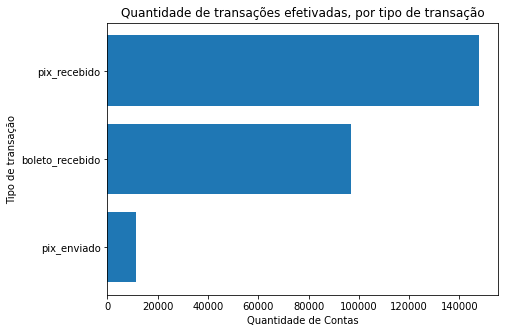

In [34]:
ids = []
for id in transactions_df['transaction_type_id']:
  if id == 1:
    ids.append('boleto_recebido')
  elif id == 2:
    ids.append('pix_enviado')
  elif id == 3:
    ids.append('pix_recebido')

transactions_df['transaction_type_id'] = ids

transacoes_df = transactions_df.groupby(['transaction_type_id']).count().reset_index().sort_values('id', ascending=True).reset_index()
transacoes_df = transacoes_df[['transaction_type_id', 'id']]
transacoes_df.rename(columns = {'id': 'quantidade'}, inplace = True)

percentual = []
total = transacoes_df['quantidade'].sum()
for quantidade in transacoes_df['quantidade']:
  percentual.append(round((quantidade / total) * 100, 2))

transacoes_df['quantidade relativa'] = percentual

transacoes_df.loc[transacoes_df.shape[0]] = ['Total', transacoes_df['quantidade'].sum(), 100]

display(transacoes_df)
print()

plt.figure(figsize=(7,5))
plt.barh(transacoes_df['transaction_type_id'].iloc[:-1], transacoes_df['quantidade'].iloc[:-1])
plt.title('Quantidade de transações efetivadas, por tipo de transação')
plt.ylabel('Tipo de transação')
plt.xlabel('Quantidade de Contas')
plt.show()

Mais de 50% das transações efetivadas foram de pix_recebidos. Mais de 95% das transações efetivadas foram de recebimento de valores.

In [35]:
boleto_recebido = (transactions_df['transaction_type_id'] == 'boleto_recebido')
pix_enviado = (transactions_df['transaction_type_id'] == 'pix_enviado')
pix_recebido = (transactions_df['transaction_type_id'] == 'pix_recebido')

valores_recebidos_boleto = transactions_df[boleto_recebido]['value']
valores_enviados_pix = transactions_df[pix_enviado]['value']
valores_recebidos_pix = transactions_df[pix_recebido]['value']

#### Como se distribuem as transações efetivadas, de acordo com os valores?

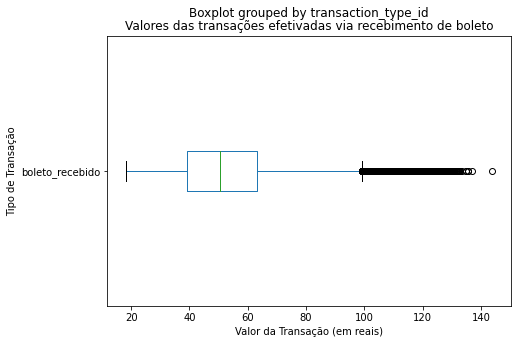

In [36]:
boxplot_boleto_recebido = transactions_df[boleto_recebido].boxplot(
    column=['value'],
    by='transaction_type_id',
    vert=False,
    figsize=(7,5))
boxplot_boleto_recebido.set_ylabel('Tipo de Transação')
boxplot_boleto_recebido.set_xlabel('Valor da Transação (em reais)')
boxplot_boleto_recebido.set_title('Valores das transações efetivadas via recebimento de boleto');
boxplot_boleto_recebido.grid(False)

Mais de 50% das transações efetivadas por recebimento de boletos tiveram valores maiores que R\$ 50. Valores maiores quem R\$ 100 representaram o valor de 25% das transações efetivadas por recebimento de boleto. 75% das transações efetivadas por recebimento de boleto tiveram valor menor que R\$ 100.

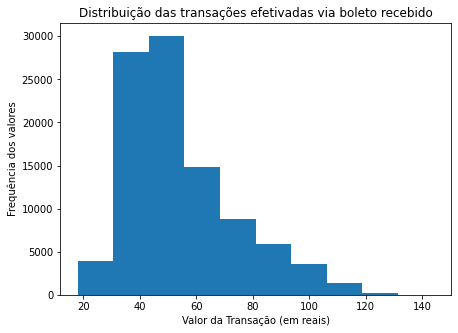

In [37]:
plt.figure(figsize=(7,5))
plt.hist(valores_recebidos_boleto, bins = 10)
plt.title('Distribuição das transações efetivadas via boleto recebido')
plt.ylabel('Frequência dos valores')
plt.xlabel('Valor da Transação (em reais)')
plt.show()

A faixa de valores entre R\$ 30 a R$ 60 apresenta a maior quantidade de transações efetivadas via recebimento de boleto. A distribuição apresenta assimetria positiva, a maior concentração de valores se encontra nos menores valores das transações.

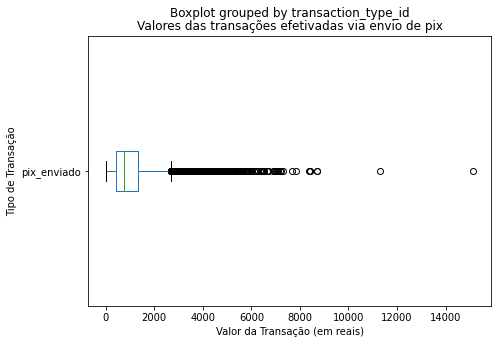

In [38]:
boxplot_pix_enviado = transactions_df[pix_enviado].boxplot(
    column=['value'],
    by='transaction_type_id',
    vert=False,
    figsize=(7,5))
boxplot_pix_enviado.set_ylabel('Tipo de Transação')
boxplot_pix_enviado.set_xlabel('Valor da Transação (em reais)')
boxplot_pix_enviado.set_title('Valores das transações efetivadas via envio de pix');
boxplot_pix_enviado.grid(False)

Mais de 50% das transações efetivadas por envio de pix tiveram valores maiores que R\$ 800. Valores maiores quem R\$ 2200 representaram o valor de 25% das transações efetivadas por envio de pix. Mais de 75% das transações efetivadas por envio de pix tiveram valor menor que R\$ 3000.

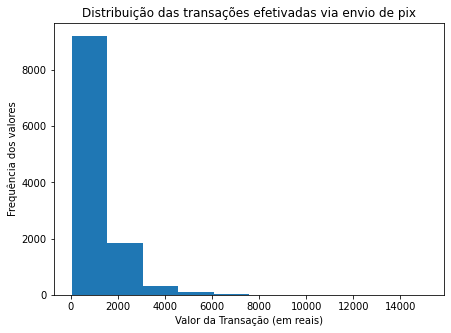

In [39]:
plt.figure(figsize=(7,5))
plt.hist(valores_enviados_pix, bins = 10)
plt.title('Distribuição das transações efetivadas via envio de pix')
plt.ylabel('Frequência dos valores')
plt.xlabel('Valor da Transação (em reais)')
plt.show()

A faixa de valores entre R\$ 0 a R$ 2000 apresenta a maior quantidade de transações efetivadas via envio de pix. A distribuição apresenta assimetria positiva, a maior concentração de valores se encontra nos menores valores das transações.

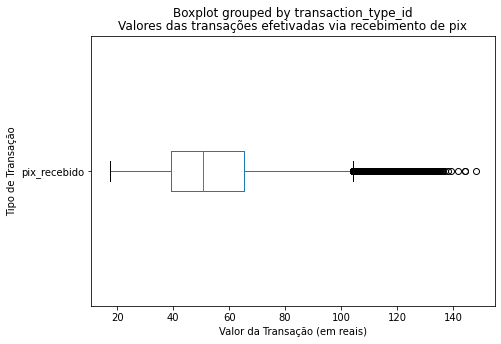

In [40]:
boxplot_pix_recebido = transactions_df[pix_recebido].boxplot(
    column=['value'],
    by='transaction_type_id',
    vert=False,
    figsize=(7,5))
boxplot_pix_recebido.set_ylabel('Tipo de Transação')
boxplot_pix_recebido.set_xlabel('Valor da Transação (em reais)')
boxplot_pix_recebido.set_title('Valores das transações efetivadas via recebimento de pix');
boxplot_pix_recebido.grid(False)

Mais de 50% das transações efetivadas por recebimento de pix tiveram valores maiores que R\$ 50. Valores maiores quem R\$ 100 representaram o valor de pouco mais de 25% das transações efetivadas por recebimento de pix. Pouco menos de 75% das transações efetivadas por recebimento de pix tiveram valor menor que R\$ 100.

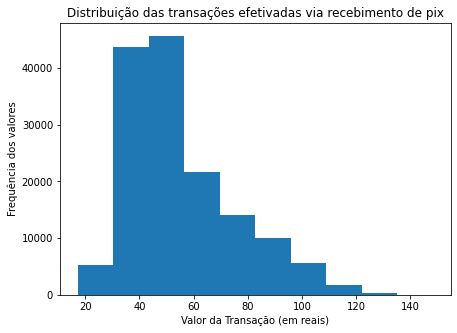

In [41]:
plt.figure(figsize=(7,5))
plt.hist(valores_recebidos_pix, bins = 10)
plt.title('Distribuição das transações efetivadas via recebimento de pix')
plt.ylabel('Frequência dos valores')
plt.xlabel('Valor da Transação (em reais)')
plt.show()

A faixa de valores entre R\$ 30 a R$ 60 apresenta a maior quantidade de transações efetivadas via recebimento de pix. A distribuição apresenta assimetria positiva, a maior concentração de valores se encontra nos menores valores das transações.

### Tabela do tipo de transações

In [42]:
transaction_types_df.head()

,id,description,description_long
0,1,boleto_recebido,BOLETO RECEBIDO PELO CLIENTE
1,2,pix_enviado,PIX ENVIADO PELO CLIENTE PARA UMA CONTA EXTERNA
2,3,pix_recebido,PIX RECEBIDO PELO CLIENTE


In [43]:
display('Tipo dos dados presentes')
display(transaction_types_df.dtypes)

'Tipo dos dados presentes'

id                   int64
description         object
description_long    object
dtype: object

id: Númerico

description: Categórico Nominal

description_long: Categórico Nominal

## 3 - Modelo para classificar as contas em lícitas ou ilícitas

### Montagem de um único dataframe contendo os dados

Adicionando cidades e estados no dataframe de contas

In [44]:
dict_address = {}
for i in range(address_df.shape[0]):
  dict_address[address_df.iloc[i]['id']] = {'estado': address_df.iloc[i]['state'], 'cidade': address_df.iloc[i]['city']}

In [45]:
contas_com_endereco = accounts_df.copy()
cidades = []
estados = []
for i in range(contas_com_endereco.shape[0]):
  cidades.append(dict_address[contas_com_endereco.iloc[i]['address_id']]['cidade'])
  estados.append(dict_address[contas_com_endereco.iloc[i]['address_id']]['estado'])
contas_com_endereco['city'] = cidades
contas_com_endereco['state'] = estados

In [46]:
contas_com_endereco.head()

,id,account_number,birth,ocupation,email,address_id,created_at,city,state
0,1,155938,1984-10-29,Outros,mariaceciliaazevedo042@example.com,1,2021-04-01 02:30:00,Carmo,RJ
1,2,747007,1977-03-26,Corretor,ananunes3@example.com,2,2021-04-01 02:00:00,Bertopolis,MG
2,3,208404,1984-01-26,Analista,luizfernandovieira@example.com,3,2021-04-01 11:30:00,Olaria,MG
3,4,66402,1982-06-30,Investidor,gabriellynascimento6@example.com,4,2021-04-01 14:30:00,Icaraima,PR
4,5,277012,1967-01-11,Outros,aliciagoncalves7@example.com,5,2021-04-02 15:30:00,Ecoporanga,ES


Adicionando nível no dataframe de contas

In [47]:
dict_levels = {}
for i in range(levels_df.shape[0]):
  dict_levels[levels_df.iloc[i]['account_number']] = levels_df.iloc[i]['level']

In [48]:
contas_com_niveis = contas_com_endereco.copy()
niveis = []
for i in range(contas_com_niveis.shape[0]):
  if contas_com_niveis.iloc[i]['account_number'] in dict_levels:
    niveis.append(dict_levels[contas_com_niveis.iloc[i]['account_number']])
  else:
    niveis.append(np.nan)

In [49]:
contas_com_niveis['level'] = niveis
contas_com_niveis.head()

,id,account_number,birth,ocupation,email,address_id,created_at,city,state,level
0,1,155938,1984-10-29,Outros,mariaceciliaazevedo042@example.com,1,2021-04-01 02:30:00,Carmo,RJ,F
1,2,747007,1977-03-26,Corretor,ananunes3@example.com,2,2021-04-01 02:00:00,Bertopolis,MG,D
2,3,208404,1984-01-26,Analista,luizfernandovieira@example.com,3,2021-04-01 11:30:00,Olaria,MG,NaN
3,4,66402,1982-06-30,Investidor,gabriellynascimento6@example.com,4,2021-04-01 14:30:00,Icaraima,PR,D
4,5,277012,1967-01-11,Outros,aliciagoncalves7@example.com,5,2021-04-02 15:30:00,Ecoporanga,ES,D


Adicionando quantidade de boletos pagos e não pagos no dataframe de  contas

In [50]:
dict_boletos_pagos = {}
dict_boletos_nao_pagos = {}
for i in range(emissoes_de_boleto_df.shape[0]):
  if emissoes_de_boleto_df.iloc[i]['status'] == 'paid':
    dict_boletos_pagos[emissoes_de_boleto_df.iloc[i]['account_number']] = emissoes_de_boleto_df.iloc[i]['quantidade']
  elif emissoes_de_boleto_df.iloc[i]['status'] == 'unpaid':
    dict_boletos_nao_pagos[emissoes_de_boleto_df.iloc[i]['account_number']] = emissoes_de_boleto_df.iloc[i]['quantidade']

In [51]:
contas_com_boletos_pagos_e_nao_pagos = contas_com_niveis.copy()
pagos = []
for i in range(contas_com_boletos_pagos_e_nao_pagos.shape[0]):
  if contas_com_boletos_pagos_e_nao_pagos.iloc[i]['account_number'] in dict_boletos_pagos:
    pagos.append(dict_boletos_pagos[contas_com_boletos_pagos_e_nao_pagos.iloc[i]['account_number']])
  else:
    pagos.append(0)

nao_pagos = []
for i in range(contas_com_boletos_pagos_e_nao_pagos.shape[0]):
  if contas_com_boletos_pagos_e_nao_pagos.iloc[i]['account_number'] in dict_boletos_nao_pagos:
    nao_pagos.append(dict_boletos_nao_pagos[contas_com_boletos_pagos_e_nao_pagos.iloc[i]['account_number']])
  else:
    nao_pagos.append(0)

In [52]:
contas_com_boletos_pagos_e_nao_pagos['amount_paid'] = pagos
contas_com_boletos_pagos_e_nao_pagos['amount_unpaid'] = nao_pagos
contas_com_boletos_pagos_e_nao_pagos.head()

,id,account_number,birth,ocupation,email,address_id,created_at,city,state,level,amount_paid,amount_unpaid
0,1,155938,1984-10-29,Outros,mariaceciliaazevedo042@example.com,1,2021-04-01 02:30:00,Carmo,RJ,F,30,39
1,2,747007,1977-03-26,Corretor,ananunes3@example.com,2,2021-04-01 02:00:00,Bertopolis,MG,D,113,153
2,3,208404,1984-01-26,Analista,luizfernandovieira@example.com,3,2021-04-01 11:30:00,Olaria,MG,NaN,64,79
3,4,66402,1982-06-30,Investidor,gabriellynascimento6@example.com,4,2021-04-01 14:30:00,Icaraima,PR,D,184,33
4,5,277012,1967-01-11,Outros,aliciagoncalves7@example.com,5,2021-04-02 15:30:00,Ecoporanga,ES,D,90,112


### A base de dados de será composta por número da conta, ocupação, quantidade de boletos pagos e de boletos não pagos. As contas com nível F serão consideradas ilícitas, classe 1, e as contas dos demais níveis serão consideradas lícitas, classe 0.

In [53]:
dataset = contas_com_boletos_pagos_e_nao_pagos[['account_number', 'ocupation', 'amount_paid', 'amount_unpaid', 'level']].copy()

list_fraud = []
for i in range(dataset.shape[0]):
  if dataset.iloc[i]['level'] == 'F':
    list_fraud.append('1')
  elif dataset.iloc[i]['level'] == 'A' or dataset.iloc[i]['level'] == 'B' or dataset.iloc[i]['level'] == 'C' or dataset.iloc[i]['level'] == 'D':
    list_fraud.append('0')
  else:
    list_fraud.append('2')

dataset['fraud'] = list_fraud

list_ocupation = []
for i in range(dataset.shape[0]):
  if dataset.iloc[i]['ocupation'] == 'Autonomo':
    list_ocupation.append(0)
  elif dataset.iloc[i]['ocupation'] == 'Investidor':
    list_ocupation.append(1)
  elif dataset.iloc[i]['ocupation'] == 'Corretor':
    list_ocupation.append(2)
  elif dataset.iloc[i]['ocupation'] == 'Desenvolvedor':
    list_ocupation.append(3)
  elif dataset.iloc[i]['ocupation'] == 'Analista':
    list_ocupation.append(4)
  elif dataset.iloc[i]['ocupation'] == 'Outros':
    list_ocupation.append(5)
    
dataset['ocupation'] = list_ocupation
dataset.reset_index()

,index,account_number,ocupation,amount_paid,amount_unpaid,level,fraud
0,0,155938,5,30,39,F,1
1,1,747007,2,113,153,D,0
2,2,208404,4,64,79,NaN,2
3,3,66402,1,184,33,D,0
4,4,277012,5,90,112,D,0
...,...,...,...,...,...,...,...
1024,1024,385922,4,0,0,D,0
1025,1025,37393,1,0,0,C,0
1026,1026,714025,2,0,0,D,0
1027,1027,708615,2,0,0,D,0


In [54]:
X_train = dataset[(dataset['fraud'] != '2')][['account_number', 'ocupation', 'amount_paid', 'amount_unpaid']]
y_train = dataset[(dataset['fraud'] != '2')]['fraud']

X_test = dataset[(dataset['fraud'] == '2')][['account_number', 'ocupation', 'amount_paid', 'amount_unpaid']]

In [55]:
X_train

,account_number,ocupation,amount_paid,amount_unpaid
0,155938,5,30,39
1,747007,2,113,153
3,66402,1,184,33
4,277012,5,90,112
5,228213,4,0,0
...,...,...,...,...
1024,385922,4,0,0
1025,37393,1,0,0
1026,714025,2,0,0
1027,708615,2,0,0


In [56]:
y_train

0       1
1       0
3       0
4       0
5       0
       ..
1024    0
1025    0
1026    0
1027    0
1028    1
Name: fraud, Length: 926, dtype: object

In [57]:
X_test

,account_number,ocupation,amount_paid,amount_unpaid
2,208404,4,64,79
6,108762,4,167,42
7,309054,3,350,385
8,89836,1,482,190
51,900180,2,128,75
...,...,...,...,...
977,905598,0,27,9
978,886210,3,0,0
993,583343,4,11,10
1008,81888,5,2,6


### Normalização do dataset

In [58]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler

train_X = np.array(X_train)
train_y = np.array(y_train)

test_X = np.array(X_test)

# Normalização dos dados
scaler = MinMaxScaler().fit(train_X)

# Normalizando dados do treinamento
train_X = scaler.transform(train_X)

# Normalizando dados do teste
test_X = scaler.transform(test_X)

### Classificação com SVC

In [59]:
from sklearn.svm import SVC

c = 100
g = 'auto'
d = 1
ke = 'poly'

clf = SVC(kernel=ke, degree=d, gamma=g, C=c)

oversample = RandomOverSampler(sampling_strategy = 'minority')

X_over, y_over = oversample.fit_resample(train_X, train_y)
  
clf.fit(X_over, y_over)
  
predicted_svc = clf.predict(test_X)
predicted_svc

array(['1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1',
       '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '0', '1',
       '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0',
       '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1',
       '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '1', '1', '1',
       '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1'],
      dtype=object)

### Classificação com Árvore de Decisão

In [60]:
from sklearn.tree import DecisionTreeClassifier

d = 3

clf = DecisionTreeClassifier(max_depth=d)

oversample = RandomOverSampler(sampling_strategy = 'minority')

X_over, y_over = oversample.fit_resample(train_X, train_y)
  
clf.fit(X_over, y_over)
  
predicted_dt = clf.predict(test_X)
predicted_dt

array(['1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1',
       '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1',
       '1', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0'],
      dtype=object)

### Classificação com Rede Neural

In [61]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='relu', solver='adam', batch_size=64, learning_rate='adaptive')

oversample = RandomOverSampler(sampling_strategy = 'minority')

X_over, y_over = oversample.fit_resample(train_X, train_y)
  
clf.fit(X_over, y_over)
  
predicted_nn = clf.predict(test_X)
predicted_nn

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


array(['1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1',
       '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0',
       '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0',
       '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1',
       '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0'],
      dtype='<U1')

### Assembleia com as saídas dos três modelos

In [62]:
predicted = []
for svc, dt, nn in zip(predicted_svc, predicted_dt, predicted_nn):
  if int(svc) + int(dt) + int(nn) > 1:
    predicted.append(1)
  else:
    predicted.append(0)
predicted

[1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0]

### Saídas preditas

In [63]:
outputs_df = pd.DataFrame()
outputs_df['account_number'] = X_test['account_number']
outputs_df['fraud'] = predicted
outputs_df = outputs_df.reset_index()
outputs_df = outputs_df[['account_number', 'fraud']]
outputs_df

,account_number,fraud
0,208404,1
1,108762,0
2,309054,0
3,89836,0
4,900180,0
...,...,...
98,905598,1
99,886210,0
100,583343,0
101,81888,1


In [64]:
output_csv = outputs_df.to_csv
output_csv('predicted.csv', sep=',', encoding='utf-8')